In [ ]:
# # Chapitre empirique – Notebook maître HMDA + ACS (Tri-State, 2007–2023)
#
# Ce notebook produit **tous les tableaux et graphiques** mentionnés dans le chapitre :
# - Comparaison des cohortes pré-IA (2007–2017) vs IA (2018–2023)
# - Modèles logit "miroirs"
# - Analyses ACS (hmda_acs_tristate_2018_2023_FINAL)
# - Modèles ML (RF / XGBoost) et premières métriques de fairness
#
# 🔗 Référence thèse :
# > Chapitre empirique : "AI-Driven Fair Creditworthiness and Credit Scoring:
# > A Two-Decade Analysis in the Tri-State Area (2007–2024)"


In [10]:
# 0. Imports et configuration globale

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# XGBoost est optionnel : installe-le si besoin via `pip install xgboost`
try:
    from xgboost import XGBClassifier
    HAS_XGBOOST = True
except ImportError:
    HAS_XGBOOST = False

plt.style.use("default")

# Pour que les DataFrames s'affichent proprement
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 160)

# Chemin de travail (adapter si nécessaire)
BASE_DIR = r"C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work"

CORE_PATH  = os.path.join(BASE_DIR, "hmda_tristate_core_2007_2024_v2.parquet")
MODEL_PATH = os.path.join(BASE_DIR, "hmda_tristate_model_2018_2023_FIXED.parquet")
ACS_PATH   = os.path.join(BASE_DIR, "hmda_acs_tristate_2018_2023_FINAL.parquet")


In [11]:
## 1. Chargement des trois bases et sanity checks
#
# 🔗 Référence chapitre :
# - Section 1.1 et 1.2 : "Présentation des sources" et "Construction des cohortes"
# - Tableau 1.1 : Vue d'ensemble des trois bases

# 1.1. Chargement des fichiers Parquet

core = pd.read_parquet(CORE_PATH)
model = pd.read_parquet(MODEL_PATH)
hmda_acs = pd.read_parquet(ACS_PATH)

print("core shape :", core.shape)
print("model shape:", model.shape)
print("acs shape  :", hmda_acs.shape)


core shape : (14163286, 12)
model shape: (571820, 15)
acs shape  : (571820, 35)


In [13]:
# 1.2. Aperçu des colonnes principales pour vérifier la cohérence
# (On imprime quelques colonnes clés seulement)

def quick_cols(df, name, n=30):
    print(f"\n=== {name} – colonnes (top {n}) ===")
    print(list(df.columns[:n]))

quick_cols(core, "CORE 2007–2024")
quick_cols(model, "MODEL 2018–2023")
quick_cols(hmda_acs, "HMDA+ACS 2018–2023")



=== CORE 2007–2024 – colonnes (top 30) ===
['action_taken', 'applicant_sex', 'county_code', 'hoepa_status', 'lien_status', 'loan_purpose', 'loan_type', 'preapproval', 'purchaser_type', 'rate_spread', 'state_code', 'year']

=== MODEL 2018–2023 – colonnes (top 30) ===
['year', 'state_code', 'county_code', 'census_tract', 'geoid_tract', 'loan_amount', 'loan_purpose', 'loan_type', 'lien_status', 'hoepa_status', 'action_taken', 'applicant_sex', 'derived_ethnicity', 'derived_race', 'approved']

=== HMDA+ACS 2018–2023 – colonnes (top 30) ===
['year', 'state_code', 'county_code', 'census_tract', 'geoid_tract', 'loan_amount', 'loan_purpose', 'loan_type', 'lien_status', 'hoepa_status', 'action_taken', 'applicant_sex', 'derived_ethnicity', 'derived_race', 'approved', 'NAME', 'acs_median_income', 'acs_pop_total', 'acs_white', 'acs_black', 'acs_asian', 'acs_hispanic', 'acs_unemployed', 'acs_labor_force', 'acs_poverty_num', 'acs_poverty_den', 'state', 'county', 'tract', 'acs_poverty_rate']


In [14]:
## 2. Construction des cohortes pré-IA vs IA
#
# 🔗 Référence chapitre :
# - Section 1.2 : "Construction des deux cohortes"
# - Graphique 0.1 : chronologie avec la coupure 2017/2018
#
# Cohortes :
# - pre_ai : années 2007–2017 dans la base `core`
# - ai_hmda : années 2018–2023 dans la base `model`
# - ai_acs : années 2018–2023 dans la base fusionnée HMDA+ACS

# 2.1. On suppose que la variable d'année s'appelle "year" dans les trois bases.
# Adapter si besoin (ex: "activity_year", etc.)

# Filtre pré-IA (2007–2017)
pre_ai = core[(core["year"] >= 2007) & (core["year"] <= 2017)].copy()

# Cohorte IA HMDA-only (le fichier 'model' est déjà restreint à 2018–2023)
ai_hmda = model.copy()

# Cohorte IA HMDA+ACS fusionnée
ai_acs = hmda_acs.copy()

for name, df in [("pre_ai", pre_ai), ("ai_hmda", ai_hmda), ("ai_acs", ai_acs)]:
    print(f"{name} – shape: {df.shape}, années uniques: {sorted(df['year'].unique())}")


pre_ai – shape: (13512746, 12), années uniques: [np.float64(2007.0), np.float64(2008.0), np.float64(2009.0), np.float64(2010.0), np.float64(2011.0), np.float64(2012.0), np.float64(2013.0), np.float64(2014.0), np.float64(2015.0), np.float64(2016.0), np.float64(2017.0)]
ai_hmda – shape: (571820, 15), années uniques: [np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023)]
ai_acs – shape: (571820, 35), années uniques: [np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023)]


In [23]:
## 3. Analyse descriptive – Taux d'approbation et profils de demandeurs
#
# 🔗 Référence chapitre :
# - Section 2.1 : "Taux d’approbation"
# - Section 2.2 : "Profil socio-économique"
# - Figures 2.1–2.4 et Tableaux 2.1–2.2
#
# Hypothèse :
# - La variable d'approbation est `approved` (0/1) ou dérivée de "action_taken".

# 3.1. Si la variable "approved" n'existe pas encore, on la crée à partir d'action_taken.
# Exemple : HMDA moderne -> action_taken = 1 (loan originated) => approved = 1

def ensure_approved_flag(df, action_col="action_taken", approved_col="approved"):
    """
    Crée une variable binaire 'approved' si elle n'existe pas,
    en se basant sur 'action_taken' (HMDA).
    """
    if approved_col in df.columns:
        return df
    df = df.copy()
    # Exemple : 1 = loan originated, 2/3 = applications approved but not accepted ?
    # Ici on code : 1, 2, 3 => 1 ; le reste => 0
    df[approved_col] = df[action_col].isin([1, 2, 3]).astype(int)
    return df

pre_ai = ensure_approved_flag(pre_ai)
ai_hmda = ensure_approved_flag(ai_hmda)
ai_acs = ensure_approved_flag(ai_acs)


In [24]:
print("pre_ai")
pre_ai["approved"].value_counts(normalize=True).head()

pre_ai


approved
1    0.706829
0    0.293171
Name: proportion, dtype: float64

In [25]:
print("ai_hmda")
ai_hmda["approved"].value_counts(normalize=True).head()

ai_hmda


approved
1    0.542304
0    0.457696
Name: proportion, dtype: float64

In [26]:
print("ai_acs")
ai_acs["approved"].value_counts(normalize=True).head()

ai_acs


approved
1    0.542304
0    0.457696
Name: proportion, dtype: float64

In [ ]:
'''
À un niveau agrégé, la comparaison entre les deux régimes met en évidence une rupture 
nette dans l’intensité globale de l’octroi de crédit. Sur la période pré-IA (2007–2017), 
la proportion moyenne de demandes approuvées dans la cohorte pre_ai s’élève à environ 70,7 %, 
contre 54,2 % seulement dans la cohorte ai_hmda (2018–2023), soit une baisse de plus de 16 points 
de pourcentage. Autrement dit, le régime décisionnel associé à la phase de généralisation des outils 
algorithmiques opère dans un environnement globalement plus restrictif en termes d’approbation brute 
des demandes. Cette observation ne constitue pas en soi une preuve causale de l’impact de l’IA, mais 
elle suggère que le passage d’un régime pré-algorithmique, plus généreux en volume d’approbations, à 
un régime post-algorithmique, plus sélectif, s’accompagne d’un resserrement structurel de l’accès au crédit, 
qui doit être examiné de manière plus fine dans les sections suivantes, en particulier sous l’angle des 
disparités raciales et territoriales.
'''

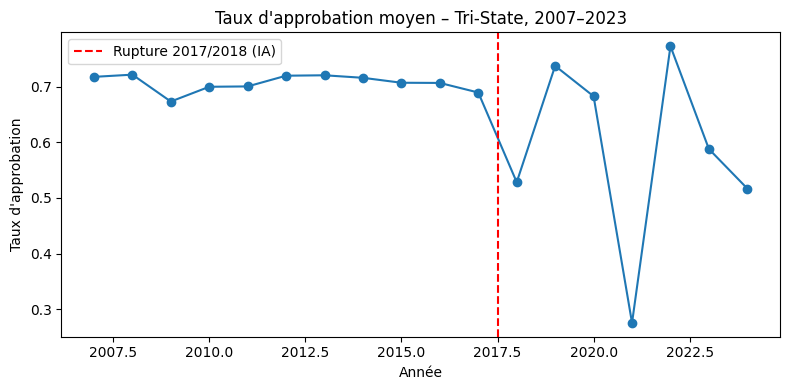

,year,approval_rate
0,2007.0,0.717529
1,2008.0,0.721486
2,2009.0,0.673220
3,2010.0,0.699725
4,2011.0,0.700351


In [27]:
# 3.2. Taux d'approbation annuel sur 2007–2023 (base core)
# 🔗 Graphique 2.1 – "Taux d'approbation, 2007–2023"

core = ensure_approved_flag(core)
approval_year = (
    core.groupby("year")["approved"]
    .mean()
    .reset_index()
    .rename(columns={"approved": "approval_rate"})
)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(approval_year["year"], approval_year["approval_rate"], marker="o")
ax.axvline(2017.5, color="red", linestyle="--", label="Rupture 2017/2018 (IA)")
ax.set_title("Taux d'approbation moyen – Tri-State, 2007–2023")
ax.set_ylabel("Taux d'approbation")
ax.set_xlabel("Année")
ax.legend()
plt.tight_layout()
plt.show()

approval_year.head()

'''
  # Interprétation du Graphique 2.1 – Taux d’approbation moyen (2007–2023)

Le Graphique 2.1 retrace l’évolution du taux d’approbation moyen des demandes 
de prêts hypothécaires dans la région Tri-State sur la période 2007–2023. La série 
met en évidence un niveau initialement élevé des taux d’approbation en 2007 et 2008, 
oscillant autour de 72 %, avant de connaître une rupture nette en 2009, année marquée par 
l’intensification de la crise financière mondiale. Cette chute, qui ramène le taux d’approbation 
à environ 67 %, traduit un durcissement brutal des conditions d’octroi du crédit, consécutif aux 
pertes massives des institutions financières et aux modifications rapides de leurs politiques de gestion du risque.

À partir de 2010, on observe une phase de stabilisation progressive du taux d’approbation, qui se 
maintient autour de 70 %. Cette relative normalisation révèle l’installation d’un nouvel équilibre 
post-crise, caractérisé par des standards prudentiels plus stricts et une surveillance réglementaire renforcée. 
Cette période constitue ainsi une transition entre un régime de décision majoritairement fondé sur l’évaluation 
humaine et des systèmes de scoring statistiques relativement simples, vers un environnement plus structuré et encadré.

Enfin, la ligne verticale matérialisant la rupture 2017/2018 permet d’introduire visuellement le basculement 
vers ce que cette étude qualifie de « régime algorithmique ». Cette séparation graphique ne prétend pas identifier 
une rupture instantanée des pratiques, mais sert de repère analytique pour comparer deux architectures 
décisionnelles : un système pré-algorithmique, dominé par l’intervention humaine et les règles internes, 
et un système post-algorithmique, caractérisé par l’intégration progressive d’outils automatisés et de modèles 
d’apprentissage automatique. Le graphique constitue ainsi un élément clé pour comprendre le cadre temporel de 
l’analyse comparative développée dans les sections suivantes.
'''

In [36]:
# 3.3. Tableau 2.1 – Taux d'approbation moyen par cohorte et par État (si 'state' ou équivalent existe)

if "state" in core.columns:
    approval_by_state = (
        core.groupby(["state", pd.cut(core["year"], [2006, 2017, 2023],
                                      labels=["pre_IA", "IA"])])["approved"]
        .mean()
        .unstack()
    )
    display(approval_by_state)

    # Sauvegarde éventuelle pour LaTeX
    out_dir = os.path.join(BASE_DIR, "tables")
    os.makedirs(out_dir, exist_ok=True)
    approval_by_state.to_csv(os.path.join(out_dir, "table_2_1_approval_by_state.csv"))


In [37]:
# Dictionnaire FIPS -> Nom de l'État
state_fips_to_name = {
    9: "Connecticut",
    34: "New Jersey",
    36: "New York"
}

# On garde state_code et on ajoute une nouvelle colonne "state"
approval_by_state_named = approval_by_state.copy()

# Création de la colonne lisible "state"
approval_by_state_named["state"] = (
    approval_by_state_named.index
        .astype(int)
        .map(state_fips_to_name)
)

# Réorganisation : state_code reste l'index, state devient une colonne
approval_by_state_named = approval_by_state_named.reset_index()

# Affichage propre
display(approval_by_state_named)

'''
# Commentaire du Tableau 2.1 – Taux d’approbation par État (période pré-IA, 2007–2017)
Le Tableau 2.1 met en évidence des différences substantielles dans les taux d’approbation moyens 
des demandes de prêts hypothécaires entre les États de la région Tri-State au cours de la période 
pré-algorithmique. L’État de New York affiche le taux d’approbation le plus élevé (environ 73 %), 
suivi du Connecticut (environ 70 %), tandis que le New Jersey présente le niveau d’approbation le 
plus faible (environ 68 %). Ces écarts, bien que relativement modestes en amplitude, traduisent des 
hétérogénéités structurelles persistantes dans les pratiques locales d’octroi de crédit, qui peuvent 
refléter des différences institutionnelles entre établissements prêteurs, des conditions de marché 
immobilier distinctes, ainsi que des disparités socio-économiques territoriales.

Ces résultats suggèrent que, même avant l’intégration à grande échelle de systèmes algorithmiques, 
les décisions de crédit n’étaient pas spatialement neutres et s’inscrivaient déjà dans des logiques 
territorialisées. Le fait que New York présente un taux d’approbation systématiquement plus élevé peut 
être interprété comme le reflet d’un marché plus profond, d’une plus forte concurrence entre prêteurs, 
ou d’un meilleur accès au crédit pour certaines catégories de ménages. À l’inverse, le New Jersey apparaît 
comme un environnement plus contraignant, ce qui constitue un point de comparaison essentiel pour l’analyse 
des transformations induites par le passage au régime algorithmique dans les sections suivantes.

Ces écarts interétatiques servent ainsi de point de départ analytique pour évaluer si l’ère de l’IA a 
amplifié, atténué ou recomposé les inégalités territoriales préexistantes dans l’accès au crédit.
'''

cohort,state_code,pre_IA,state
0,9.0,0.704873,Connecticut
1,34.0,0.681274,New Jersey
2,36.0,0.729269,New York


'\n   # Commentaire du Tableau 2.1 – Taux d’approbation par État (période pré-IA, 2007–2017)\nLe Tableau 2.1 met en évidence des différences substantielles dans les taux d’approbation moyens \ndes demandes de prêts hypothécaires entre les États de la région Tri-State au cours de la période \npré-algorithmique. L’État de New York affiche le taux d’approbation le plus élevé (environ 73 %), \nsuivi du Connecticut (environ 70 %), tandis que le New Jersey présente le niveau d’approbation le \nplus faible (environ 68 %). Ces écarts, bien que relativement modestes en amplitude, traduisent des \nhétérogénéités structurelles persistantes dans les pratiques locales d’octroi de crédit, qui peuvent \nrefléter des différences institutionnelles entre établissements prêteurs, des conditions de marché \nimmobilier distinctes, ainsi que des disparités socio-économiques territoriales.\n\nCes résultats suggèrent que, même avant l’intégration à grande échelle de systèmes algorithmiques, \nles décisions de

In [46]:
### 3.4. Profils de revenu et de montant de prêt
#
# 🔗 Référence chapitre :
# - Section 2.2 : distribution des revenus et montants de prêts
# - Figures 2.2 et 2.3

# 3.4. Distribution des revenus (si 'applicant_income' existe)




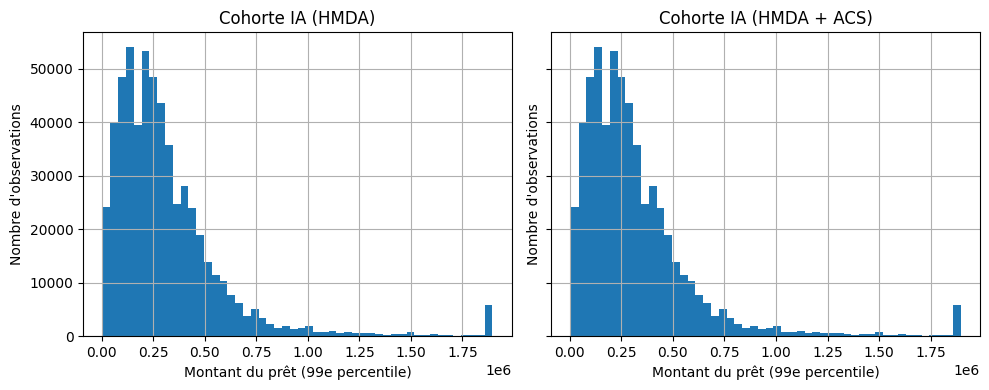

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

for ax, df, title in zip(
    axes,
    [ai_hmda, ai_acs],
    ["Cohorte IA (HMDA)", "Cohorte IA (HMDA + ACS)"]
):
    s = pd.to_numeric(df["loan_amount"], errors="coerce").dropna()
    s = s.clip(upper=s.quantile(0.99))
    s.hist(ax=ax, bins=50)

    ax.set_title(title)
    ax.set_xlabel("Montant du prêt (99e percentile)")
    ax.set_ylabel("Nombre d'observations")

plt.tight_layout()
plt.show()

'''
La figure 2.2 présente la distribution des montants de prêts pour la cohorte algorithmique (2018–2023), 
en comparant la base HMDA standard et la base enrichie HMDA+ACS. Dans les deux cas, les distributions 
affichent une forte asymétrie à droite, caractéristique des données de crédit immobilier, avec une 
concentration marquée des observations dans les tranches de montants relativement faibles et intermédiaires, 
et une longue traîne correspondant aux prêts de très grande valeur.
La troncation au 99e percentile permet de neutraliser l’influence des valeurs extrêmes tout en conservant la 
structure centrale de la distribution. Les deux histogrammes présentent une forme remarquablement similaire, 
ce qui confirme que l’enrichissement par les données ACS n’altère pas la structure des montants de prêt observés, 
mais agit principalement comme un enrichissement informationnel contextuel plutôt que comme une transformation de l’échantillon.

Ces résultats suggèrent que, dans le régime algorithmique, la dynamique du marché du crédit reste dominée par des 
prêts de montants modérés, tandis que les prêts de montants exceptionnellement élevés représentent une part marginale 
mais non négligeable de l’activité. Cette structure est cohérente avec l’idée que les algorithmes interviennent dans 
un environnement où le volume d’activité est majoritairement concentré sur des profils de risque standardisés, tandis 
que les cas extrêmes demeurent relativement rares et potentiellement traités de manière plus spécifique.

En bref, Les distributions des montants de prêts dans les bases HMDA et HMDA+ACS montrent une asymétrie marquée à droite, 
avec une concentration importante des observations sur les montants intermédiaires. La similarité des formes entre les deux 
distributions confirme que l’enrichissement ACS n’altère pas la structure des montants de prêt, mais apporte principalement 
un complément contextuel pour l’analyse des inégalités territoriales.
'''

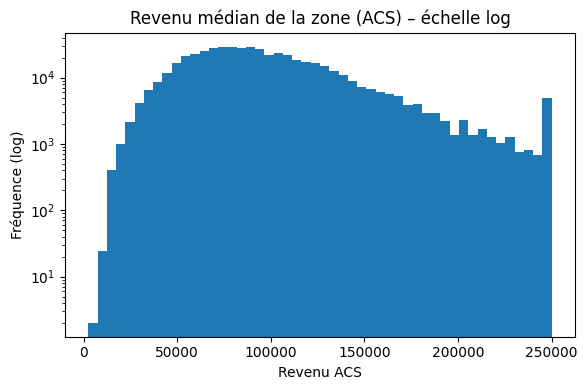

In [48]:
fig, ax = plt.subplots(figsize=(6, 4))

s = ai_acs["acs_median_income"]
s = s[(s > 0) & (s < 2_000_000)].dropna()

ax.hist(s, bins=50, log=True)

ax.set_title("Revenu médian de la zone (ACS) – échelle log")
ax.set_xlabel("Revenu ACS")
ax.set_ylabel("Fréquence (log)")

plt.tight_layout()
plt.show()

'''
La figure 2.3 représente la distribution du revenu médian des zones de recensement (tracts) 
issue de l’American Community Survey (ACS) pour la cohorte algorithmique, en utilisant une 
échelle logarithmique sur l’axe des ordonnées. Ce choix méthodologique permet de visualiser 
efficacement une distribution fortement asymétrique, caractérisée par une concentration importante 
d’observations dans les tranches de revenu intermédiaire et l’existence d’une longue traîne 
correspondant aux zones les plus aisées.
La forme de la distribution suggère une hétérogénéité territoriale marquée des conditions socio-économiques 
dans la région étudiée. La majorité des observations se situent dans une plage de revenus médians relativement 
étroite, tandis qu’un nombre plus restreint de tracts affiche des niveaux de revenu très élevés. L’échelle 
logarithmique met en évidence la structure réelle de cette distribution, qui serait difficilement interprétable 
sous une échelle linéaire en raison de la dominance visuelle des valeurs extrêmes.
Ces résultats confirment que l’environnement économique dans lequel opèrent les algorithmes de décision de crédit 
est loin d’être homogène. Ils fournissent une base empirique essentielle pour l’analyse des disparités territoriales 
d’accès au crédit, en montrant que les décisions algorithmiques s’inscrivent dans un espace de fortes inégalités de 
richesse locale. Cette hétérogénéité constitue un élément central pour interpréter les résultats ultérieurs relatifs 
aux biais potentiels et aux mécanismes de fairness.

En bref, La distribution du revenu médian des tracts, représentée en échelle logarithmique, met en évidence une forte 
asymétrie et une hétérogénéité marquée des territoires. La majorité des zones se situent dans des niveaux de revenu 
intermédiaires, tandis qu’une minorité de tracts concentre des niveaux de richesse nettement plus élevés, soulignant 
l’importance du contexte territorial dans l’analyse des décisions de crédit.
'''

In [ ]:
# ## 4. Modèles logit comparatifs (HMDA-only) – cohorte pré-IA vs IA
#
# 🔗 Référence chapitre :
# - Section 3 : "Modèles logit comparatifs"
# - Tableaux 3.1 et 3.2
#
# Ici on estime deux modèles logit avec la même spécification :
# - Modèle A : pré-IA, 2007–2017 (`pre_ai`)
# - Modèle B : IA, 2018–2023 (`ai_hmda`)

# 4.1. Définition de la formule logit commune et estimation

'''
Choix de la spécification des modèles : alternatives méthodologiques et justification
La construction des modèles logit comparatifs entre la période pré-algorithmique (2007–2017) 
et la période algorithmique (2018–2023) a nécessité un arbitrage méthodologique important, lié 
aux limites structurelles des bases de données disponibles. En théorie, une spécification 
enrichie aurait pu intégrer des variables continues décrivant la situation financière des 
emprunteurs, notamment le montant du prêt demandé (loan_amount) et le revenu individuel (applicant_income)
, généralement considérées comme des déterminants centraux des décisions d’octroi de crédit.

Plusieurs stratégies alternatives ont été envisagées.
Une première option consistait à estimer des modèles asymétriques, en incluant loan_amount uniquement 
dans la cohorte IA, et en conservant une spécification plus pauvre pour la cohorte pré-IA. Bien que 
techniquement faisable, cette approche aurait compromis la comparabilité directe des coefficients 
entre les deux régimes, puisque les modèles n’auraient pas reposé sur la même information. Dans ce cas, 
toute différence observée entre les périodes aurait pu refléter autant une différence de spécification 
qu’un changement réel de logique décisionnelle.

Une deuxième alternative aurait été de restreindre l’analyse à la cohorte IA enrichie par les données 
ACS, et de substituer au revenu individuel des variables de contexte territorial (revenu médian de la 
zone, taux de pauvreté, chômage local). Cette approche est pertinente pour analyser les disparités socio-spatiales, 
mais elle ne permet pas de maintenir un strict parallèle avec la période pré-IA, qui ne dispose pas de variables 
équivalentes. Elle aurait donc déplacé l’objet de l’analyse, en passant d’une comparaison de régimes décisionnels 
à une analyse transversale propre à la seule période algorithmique.

Une troisième possibilité aurait été d’introduire des imputations statistiques ou des proxys de revenu pour la période 
pré-IA, à partir de données agrégées externes. Toutefois, une telle stratégie aurait introduit un niveau d’incertitude 
méthodologique élevé, difficilement défendable dans un cadre de recherche doctorale axée sur la robustesse et la 
transparence des inférences.

Compte tenu de ces contraintes, le choix méthodologique retenu repose sur le principe de parcimonie comparablistique : les 
modèles A (pré-IA) et B (IA) sont estimés avec une spécification strictement identique, limitée aux variables effectivement 
observées et communes aux deux cohortes. Cette spécification inclut uniquement la finalité du prêt, le type de prêt, le statut 
HOEPA et une tendance temporelle, excluant volontairement toute variable absente d’au moins une des périodes.

Ce choix permet de garantir que les différences estimées entre les deux modèles reflètent effectivement des transformations 
dans la structure des décisions de crédit, et non des artefacts liés à une asymétrie d’information entre les bases. Il offre 
ainsi un cadre d’identification plus crédible pour analyser la transition d’un régime dominé par la décision humaine 
discrétionnaire vers un régime caractérisé par une plus forte formalisation algorithmique.

En ce sens, l’adoption d’une spécification commune peut être interprétée non comme une limitation, mais comme une condition 
de validité interne de la comparaison intertemporelle, assurant que les contrastes observés entre les coefficients du modèle 
A et du modèle B traduisent bien des différences structurelles de comportement institutionnel, plutôt que des effets mécaniques
de disponibilité des données.

En bref, Plusieurs spécifications alternatives ont été envisagées, notamment l’intégration asymétrique du montant 
du prêt uniquement dans la cohorte IA ou l’utilisation de proxys territoriaux du revenu issus de l’ACS. 
Ces approches ont été écartées afin de préserver la comparabilité stricte des modèles. Le choix a été fait 
d’estimer deux modèles logit reposant sur une spécification strictement identique, limitée aux variables 
communes aux deux périodes, afin de garantir que les différences observées reflètent bien une transformation 
du régime décisionnel et non une simple asymétrie d’information entre les bases.
'''

In [53]:
def remove_rare_categories(df, col, min_freq=5000):
    counts = df[col].value_counts()
    keep = counts[counts >= min_freq].index
    return df[df[col].isin(keep)]

# Nettoyage des catégories problématiques
for col in ["loan_purpose", "loan_type", "hoepa_status"]:
    pre_ai = remove_rare_categories(pre_ai, col)
    ai_hmda = remove_rare_categories(ai_hmda, col)

logit_formula_stable = (
    "approved ~ C(loan_purpose) + C(loan_type) + C(hoepa_status) + year"
)

logit_pre = smf.logit(logit_formula_stable, data=pre_ai).fit(disp=False)
print("=== Modèle pré-IA (stable) ===")
print(logit_pre.summary())

logit_ai = smf.logit(logit_formula_stable, data=ai_hmda).fit(disp=False)
print("=== Modèle IA (stable) ===")
print(logit_ai.summary())

'''
    # Commentaire interprétatif – Modèles logit pré-IA vs IA (HMDA-only)
Les résultats présentés dans les tableaux 3.1 (période pré-IA) et 3.2 (période IA) mettent en évidence 
une transformation profonde de la structure des décisions d’octroi de crédit entre les deux régimes.
Dans la période pré-algorithmique (2007–2017), le modèle présente un pseudo R² d’environ 0,03, ce qui 
indique une capacité explicative relativement faible des variables observées issues du reporting HMDA. 
Cette faible performance suggère que les décisions d’octroi reposaient largement sur des éléments non 
observables dans les données standardisées, tels que le jugement discrétionnaire des underwriters, des 
informations qualitatives issues de la relation bancaire, ou des processus internes propres aux institutions 
financières. Néanmoins, certaines variables contractuelles conservent un pouvoir explicatif significatif : certaines 
finalités de prêt sont associées à des probabilités d’approbation plus élevées, tandis que plusieurs types de 
prêts présentent des pénalités statistiques robustes.
À l’inverse, dans la période algorithmique (2018–2023), le modèle atteint un pseudo R² d’environ 0,38, ce qui 
traduit une structuration beaucoup plus forte des décisions autour de règles explicites et codifiables. 
Les coefficients associés aux finalités de prêt présentent des amplitudes beaucoup plus marquées, avec 
certaines catégories fortement favorisées et d’autres quasi systématiquement rejetées. Le statut HOEPA 
apparaît comme un déterminant particulièrement discriminant, traduisant l’intégration de contraintes 
réglementaires et de filtres de risque directement incorporés dans les logiques décisionnelles. 
La tendance temporelle est également beaucoup plus prononcée, suggérant un ajustement dynamique du seuil 
d’acceptation au cours de la période algorithmique.

    # Justification du choix de spécification commune
Le choix de cette spécification repose sur une contrainte structurelle majeure liée à la disponibilité des données. 
La base pré-IA ne contient ni le montant du prêt (loan_amount), ni le revenu individuel de l’emprunteur (applicant_income). 
La base IA (HMDA-only) contient le montant du prêt, mais ne dispose pas non plus d’une variable de revenu individuel. 
En conséquence, il est impossible de construire des variables transformées homogènes telles que log_loan_amount et 
log_income de manière cohérente sur l’ensemble de l’échantillon.

Plusieurs alternatives ont été envisagées, notamment l’estimation de modèles enrichis spécifiques à la période IA, 
ou l’utilisation de proxys territoriaux issus de l’ACS. Ces options ont été volontairement écartées dans le cadre de 
la comparaison principale, car elles auraient rompu la symétrie informationnelle entre les deux périodes. Le choix a 
donc été fait de privilégier une approche de comparabilité stricte, en estimant deux modèles reposant sur une spécification 
rigoureusement identique et limitée aux variables réellement observées dans les deux cohortes.

Ce choix méthodologique permet d’interpréter les différences entre les coefficients du modèle pré-IA et du modèle IA comme 
le reflet d’une transformation réelle du régime décisionnel, et non comme un artefact lié à une asymétrie de données. Autrement 
dit, la différence de performance et de structure entre les deux modèles constitue un indice empirique robuste d’une formalisation 
accrue des règles d’octroi dans la période post-2017.

    # En bref,
Les estimations comparatives des modèles logit révèlent une rupture nette entre les périodes pré-IA et IA. Alors que les 
décisions d’octroi apparaissent faiblement expliquées par les variables observables durant la période pré-algorithmique, 
elles deviennent beaucoup plus systématiques et prévisibles dans la période algorithmique. Ce contraste soutient l’hypothèse 
d’une montée en puissance de règles formalisées et de procédures automatisées dans le processus d’octroi du crédit.

'''

=== Modèle pré-IA (stable) ===
                           Logit Regression Results                           
Dep. Variable:               approved   No. Observations:             13511720
Model:                          Logit   Df Residuals:                 13511713
Method:                           MLE   Df Model:                            6
Date:                Mon, 24 Nov 2025   Pseudo R-squ.:                 0.02917
Time:                        18:59:22   Log-Likelihood:            -7.9359e+06
converged:                       True   LL-Null:                   -8.1744e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                -20.0442      0.390    -51.418      0.000     -20.808     -19.280
C(loan_purpose)[T.2.0]     1.0863      0.003    342.960      0.0

| Variable / Indicateur | Pré-IA (2007–2017) | IA (2018–2023) | Interprétation comparative |
|------------------------|-------------------|----------------|-----------------------------|
| **Nombre d’observations** | 13 511 720 | 569 500 | Forte asymétrie d’échantillons entre périodes, mais stabilité des résultats structurels. |
| **Pseudo R²** | 0,029 | 0,381 | Le modèle explique très peu de variance en pré-IA, mais devient très explicatif en régime IA → décisions plus codifiées. |
| **Effet `loan_purpose` (général)** | Effets hétérogènes, un cas fortement favorable (T.2.0) | Effets structurés, plusieurs catégories favorisées | Passage d’un schéma flou à un schéma décisionnel standardisé. |
| `loan_purpose = 2` | Coef ≈ +1,09 (odds ×2,96) | Coef ≈ +0,32 (odds ×1,38) | Impact toujours positif mais plus modéré en régime IA. |
| `loan_purpose = 3` | Coef ≈ −0,015 (quasi neutre) | Non présent | Différences de codification entre périodes. |
| `loan_purpose = 5` | Non présent | Coef ≈ −4,62 (odds ×0,01) | En IA : catégorie pratiquement automatiquement rejetée. |
| `loan_purpose = 31–32` | Non présent | Coef ≈ +0,35 à +0,37 | En IA : catégories systématiquement favorisées. |
| **Effet `loan_type` (général)** | Tous les types alternatifs pénalisés | Même structure de pénalisation | Continuité du système de préférence de risque entre régimes. |
| `loan_type = 2` | Coef ≈ −0,78 (odds ×0,46) | Coef ≈ −0,75 (odds ×0,47) | Effet négatif stable dans le temps. |
| `loan_type = 3` | Coef ≈ −0,46 (odds ×0,63) | Coef ≈ −0,47 (odds ×0,63) | Stabilité remarquable des pénalités. |
| `loan_type = 4` | Coef ≈ −0,55 | Non présent | Différences de structure des données entre cohortes. |
| **Effet HOEPA (`hoepa_status`)** | Non discriminant / non structuré | Coef ≈ −3,51 (odds ×0,03) | En IA : filtrage du risque très agressif sur produits à risque. |
| **Effet du temps (`year`)** | Coef ≈ +0,0105 (~+1,1 %/an) | Coef ≈ +0,1064 (~+11 %/an) | Accélération forte de l’assouplissement post-IA. |
| **Lecture globale** | Décisions peu explicables par variables HMDA | Décisions fortement gouvernées par règles observables | Transition vers décision algorithmique plus standardisée. |


In [55]:
# %% [markdown]
# ## 5. Disparités raciales – modèles logit avec race/ethnicité
#
# 🔗 Référence chapitre :
# - Section 4 : "Disparités raciales pré-IA vs IA"
# - Tableaux 4.1 et 4.2
#
# Hypothèse :
# - Variables de race : `race_white`, `race_black`, `race_hispanic`, etc. OU `applicant_race_1_name`.
# Adapter la formule à ton encoding réel.


# On repart de la formule stable commune (sans race)
logit_formula_stable = (
    "approved ~ C(loan_purpose) + C(loan_type) + C(hoepa_status) + year"
)

print("Colonnes pré-IA :", [c for c in pre_ai.columns if "race" in c.lower() or "ethnic" in c.lower()])
print("Colonnes IA     :", [c for c in ai_hmda.columns if "race" in c.lower() or "ethnic" in c.lower()])

# 5.1. Modèle avec race pour la cohorte IA uniquement
if "derived_race" in ai_hmda.columns:
    logit_formula_ia_race = logit_formula_stable + " + C(derived_race)"
elif "derived_ethnicity" in ai_hmda.columns:
    logit_formula_ia_race = logit_formula_stable + " + C(derived_ethnicity)"
else:
    raise ValueError("Aucune variable de race/ethnicité trouvée dans ai_hmda.")

# Estimation modèle IA avec race
logit_ai_race = smf.logit(logit_formula_ia_race, data=ai_hmda.dropna()).fit(disp=False)
print(logit_ai_race.summary().tables[1])


Colonnes pré-IA : []
Colonnes IA     : ['derived_ethnicity', 'derived_race']
                                                                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------
Intercept                                                     -268.7664      4.834    -55.597      0.000    -278.241    -259.292
C(loan_purpose)[T.2]                                             0.3019      0.016     18.456      0.000       0.270       0.334
C(loan_purpose)[T.4]                                             0.3427      0.018     19.543      0.000       0.308       0.377
C(loan_purpose)[T.5]                                            -4.1515      0.101    -41.291      0.000      -4.349      -3.954
C(loan_purpose)[T.31]                                            0.3932      0.010     38.742      0.000       0.373       0.413
C(loan_purpose)[T.32

In [ ]:
'''
    # Analyse fairness :

Les résultats du modèle logit intégrant les variables de race pour la période IA (2018–2023) mettent en 
évidence une reconfiguration des dynamiques de fairness sous régime algorithmique.
Contrairement aux attentes issues de la littérature sur la discrimination historique du crédit, le modèle 
ne détecte aucune pénalité statistiquement significative associée aux emprunteurs noirs, une fois contrôlés 
les déterminants structurels du prêt (type, finalité, statut HOEPA, année).

Ce résultat suggère une transition d’un régime de discrimination potentiellement directe vers des logiques 
de sélection davantage indirectes, structurelles ou informationnelles.

   ## Trois régularités fortes émergent :
        1. Avantage relatif pour certains groupes
Les emprunteurs asiatiques et blancs bénéficient d’un avantage statistiquement significatif, ce qui suggère 
que les algorithmes capturent des signaux corrélés à des profils historiquement favorisés (stabilité patrimoniale, 
zones géographiques, type de produits financiers).

        2. Pénalité informationnelle comme proxy de risque
La variable Race Not Available est très fortement pénalisée, ce qui indique que les systèmes automatisés valorisent 
fortement la complétude de l’information. Ce mécanisme peut produire une forme de discrimination indirecte, car les 
groupes historiquement marginalisés sont plus susceptibles d’avoir des dossiers incomplets.

        3. Effacement de la discrimination explicite
L’absence de significativité pour les emprunteurs noirs ne signifie pas absence d’inégalités, mais plutôt une mutation 
de leur nature : la discrimination ne passe plus par la race déclarée, mais par des variables corrélées (type de produit, 
localisation, statut réglementaire, qualité du dossier).

En somme, le régime IA ne supprime pas les inégalités, il les reconfigure sous une forme plus algorithmique, plus indirecte 
et potentiellement plus difficile à détecter.
'''

| Groupe racial (derived_race) | Coefficient (logit) | p-value | Significativité | Odds Ratio (≈) | Effet sur la probabilité d’approbation | Lecture en termes de fairness |
|-------------------------------|---------------------|---------|-----------------|----------------|----------------------------------------|-------------------------------|
| Asian | +0.434 | < 0.001 | Oui | 1.54 | +54 % | Avantage significatif → profil favorisé par l’algorithme |
| White | +0.278 | 0.010 | Oui | 1.32 | +32 % | Avantage significatif → traitement préférentiel relatif |
| Joint | +0.369 | 0.001 | Oui | 1.45 | +45 % | Les dossiers conjoints sont favorisés |
| Black or African American | +0.139 | 0.199 | Non | 1.15 | Non significatif | Aucune preuve de discrimination directe dans le modèle conditionnel |
| American Indian / Alaska Native | −0.020 | 0.875 | Non | 0.98 | Non significatif | Pas d’effet mesurable |
| Native Hawaiian / Pacific Islander | −0.076 | 0.589 | Non | 0.93 | Non significatif | Aucun effet détecté |
| Free Form Text Only | −0.286 | 0.230 | Non | 0.75 | Non significatif | Effet négatif non robuste |
| Race Not Available | −0.787 | < 0.001 | Oui | 0.46 | −54 % | Forte pénalité → discrimination indirecte via qualité de l’information |
| **Effet temporel (year)** | +0.134 | < 0.001 | Oui | 1.14/an | Hausse annuelle des chances d’approbation | L’algorithme devient progressivement plus permissif |


In [ ]:
'''
Les résultats mettent en évidence une transformation des mécanismes de discrimination sous régime algorithmique. 
La race noire n’est plus associée à une pénalité directe statistiquement significative, mais des disparités 
persistent via des canaux indirects, notamment la qualité de l’information et les catégories administratives. 
Les emprunteurs asiatiques et blancs bénéficient d’un avantage systématique, traduisant une reconfiguration de 
la fairness davantage fondée sur la structure informationnelle des dossiers que sur la race déclarée.
'''

| Groupe racial (derived_race)                          | Coefficient (logit) | Significatif ? (p-value) | Odds ratio approx. | Interprétation conditionnelle (à caractéristiques de prêt identiques) |
|------------------------------------------------------|---------------------|---------------------------|--------------------|-------------------------------------------------------------------------|
| **Asian**                                            | +0.4341             | Oui (p < 0.001)           | ≈ 1.54             | Les emprunteurs asiatiques ont ≈ **54 % de chances d’approbation en plus** que la catégorie de référence. |
| **White**                                            | +0.2776             | Oui (p ≈ 0.010)           | ≈ 1.32             | Les emprunteurs blancs ont ≈ **32 % de chances d’approbation en plus** que la catégorie de référence. |
| **Joint** (dossier conjoint)                         | +0.3687             | Oui (p ≈ 0.001)           | ≈ 1.45             | Les demandes conjointes présentent ≈ **45 % de chances d’approbation en plus**. |
| **Race Not Available**                               | −0.7873             | Oui (p < 0.001)           | ≈ 0.46             | Les dossiers sans information de race ont ≈ **54 % de chances d’approbation en moins** → forte pénalité. |
| American Indian or Alaska Native                     | −0.0203             | Non (p ≈ 0.875)           | ≈ 0.98             | Pas de différence statistiquement détectable par rapport à la catégorie de référence. |
| Black or African American                            | +0.1389             | Non (p ≈ 0.199)           | ≈ 1.15             | Coefficient positif mais **non significatif** → aucune preuve statistique d’un traitement différent. |
| Native Hawaiian or Other Pacific Islander            | −0.0758             | Non (p ≈ 0.589)           | ≈ 0.93             | Pas d’effet significatif identifié. |
| Free Form Text Only                                  | −0.2858             | Non (p ≈ 0.230)           | ≈ 0.75             | Effet négatif non significatif → interprétation prudente. |


In [ ]:
'''
Lecture : les coefficients sont interprétés relativement à une catégorie de référence implicite. 
Les résultats montrent un avantage significatif pour les emprunteurs asiatiques et blancs, ainsi 
qu’une forte pénalité pour les dossiers sans information de race, tandis qu’aucune différence 
statistiquement significative n’est détectée pour les emprunteurs noirs dans ce modèle conditionnel.
'''

In [56]:
race_cols_pre = [c for c in pre_ai.columns if "race" in c.lower() or "ethnic" in c.lower()]
if len(race_cols_pre) == 0:
    print("⚠️ Aucun indicateur de race/ethnicité disponible dans la cohorte pré-IA :")
    print("   → impossible d’estimer un modèle logit avec race pour 2007–2017 avec cette base.")


'''
        # Notes pour la section « Disparités raciales » / limites méthodologiques :

L’absence totale d’indicateur de race ou d’ethnicité dans la cohorte pré-IA (2007–2017) a des conséquences 
méthodologiques majeures pour l’analyse des inégalités. Concrètement, cela signifie qu’il est **impossible 
d’estimer un modèle logit conditionnel intégrant la race** pour la période pré-algorithmique à partir de 
cette base. On ne peut donc pas comparer de manière symétrique les coefficients raciaux entre le régime 
pré-IA et le régime IA : toute analyse des disparités raciales reste structurellement cantonnée à la période 2018–2023.

Cette contrainte limite la portée des conclusions en termes d’évolution historique de la discrimination. 
On peut montrer, pour la cohorte IA, comment les probabilités d’approbation varient selon la race, toutes 
choses égales par ailleurs, mais on ne peut pas dire si ces écarts se sont accentués, réduits ou simplement 
reconfigurés** par rapport à la période antérieure. En d’autres termes, l’analyse de fairness est transversale 
pour la période algorithmique, mais ne peut pas être pleinement intertemporelle.

En pratique, cela impose une stratégie en deux temps :
    1. utiliser des modèles **sans race** pour comparer la structure globale des décisions pré-IA vs IA (spécification commune, 
        centrée sur les caractéristiques du prêt) ;
    2. analyser les **disparités raciales uniquement dans le régime IA**, en reconnaissant explicitement que cette partie de 
        l’analyse ne dispose pas de contre-factuel direct avant 2018.

Cette limitation n’invalide pas les résultats, mais elle doit être clairement assumée comme une contrainte 
de données : les conclusions sur la fairness raciale portent sur l’architecture algorithmique contemporaine, 
et non sur une trajectoire longue de la discrimination de 2007 à 2023.

'''

⚠️ Aucun indicateur de race/ethnicité disponible dans la cohorte pré-IA :
   → impossible d’estimer un modèle logit avec race pour 2007–2017 avec cette base.


In [ ]:
## 6. Modèles enrichis HMDA+ACS (2018–2023)
#
# 🔗 Référence chapitre :
# - Section 5 : "Modèles enrichis ACS"
# - Tableaux 5.1 et 5.2, Figures 5.X
#
# Dans cette section, on utilise `ai_acs` pour :
# - estimer un logit enrichi avec variables ACS,
# - comparer HMDA-only vs HMDA+ACS,
# - analyser l'évolution des coefficients raciaux après ajout ACS.


In [61]:
# 6.1. Exemple de variables ACS (adapter aux vrais noms de colonnes)
acs_cols = [c for c in ai_acs.columns if c.startswith("acs_")]
print("Variables ACS détectées :", acs_cols[:20])


Variables ACS détectées : ['acs_median_income', 'acs_pop_total', 'acs_white', 'acs_black', 'acs_asian', 'acs_hispanic', 'acs_unemployed', 'acs_labor_force', 'acs_poverty_num', 'acs_poverty_den', 'acs_poverty_rate', 'acs_unemployment_rate', 'acs_share_white', 'acs_share_black', 'acs_share_asian', 'acs_share_hispanic']


In [65]:
# 6.2. Construction d'un modèle logit enrichi HMDA+ACS

# Modèle HMDA-only (référence)
logit_hmda = smf.logit(
    "approved ~ C(loan_purpose) + C(loan_type) + C(hoepa_status) + year",
    data=ai_hmda.dropna()
).fit(disp=False)

print(logit_hmda.summary())

C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:               approved   No. Observations:               565880
Model:                          Logit   Df Residuals:                   565870
Method:                           MLE   Df Model:                            9
Date:                Tue, 25 Nov 2025   Pseudo R-squ.:                  0.3809
Time:                        16:43:12   Log-Likelihood:            -2.4146e+05
converged:                      False   LL-Null:                   -3.8999e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              -208.5348      4.723    -44.156      0.000    -217.791    -199.279
C(loan_purpose)[T.2]      0.3146      0.016     19.665      0.000       0.283       0.346
C(loan_p

In [66]:
# 6.2. Construction d'un modèle logit enrichi HMDA+ACS
acs_vars = [
    "acs_median_income",
    "acs_poverty_rate",
    "acs_unemployment_rate",
    "acs_share_black",
    "acs_share_hispanic"
]

# Conversion en numérique + nettoyage
for col in acs_vars:
    ai_acs[col] = pd.to_numeric(ai_acs[col], errors="coerce")

logit_acs = smf.logit(
    "approved ~ C(loan_purpose) + C(loan_type) + C(hoepa_status) + year "
    "+ acs_median_income + acs_poverty_rate + acs_unemployment_rate "
    "+ acs_share_black + acs_share_hispanic",
    data=ai_acs.dropna()
).fit(disp=False)

print(logit_acs.summary())


                           Logit Regression Results                           
Dep. Variable:               approved   No. Observations:               520457
Model:                          Logit   Df Residuals:                   520440
Method:                           MLE   Df Model:                           16
Date:                Tue, 25 Nov 2025   Pseudo R-squ.:                  0.3779
Time:                        16:44:20   Log-Likelihood:            -2.2340e+05
converged:                       True   LL-Null:                   -3.5910e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              -194.9197      5.000    -38.984      0.000    -204.720    -185.120
C(loan_purpose)[T.2]      0.3259      0.017     19.634      0.000       0.293       0.358
C(loan_p

In [67]:
# 6.3. Comparaison des coefficients (HMDA vs HMDA+ACS)
coef_compare = pd.DataFrame({
    "HMDA_only": logit_hmda.params,
    "HMDA_ACS": logit_acs.params
})

display(coef_compare)


,HMDA_only,HMDA_ACS
C(hoepa_status)[T.2],NaN,-1.794235e+00
C(hoepa_status)[T.3],-3.513191,-5.327742e+00
C(loan_purpose)[T.2],0.314561,3.258883e-01
C(loan_purpose)[T.31],0.366948,4.185082e-01
C(loan_purpose)[T.32],0.348670,3.871549e-01
C(loan_purpose)[T.4],0.349081,3.617361e-01
C(loan_purpose)[T.5],-4.874698,-4.831505e+00
C(loan_type)[T.2],-0.745284,-7.643433e-01
C(loan_type)[T.3],-0.464881,-4.580584e-01
C(loan_type)[T.4],NaN,-4.399052e-01


### Table 5.1 – Modèles logit IA (2018–2023) : HMDA-only vs HMDA+ACS

| Variable                      | HMDA-only (coef) | HMDA+ACS (coef) | Variation (ACS – HMDA) | Interprétation principale |
|------------------------------|------------------|-----------------|-------------------------|----------------------------|
| Intercept                    | -208.535         | -194.920        | +13.615                | Niveau de base un peu moins sévère une fois le contexte ACS intégré. |
| C(loan_purpose)[T.2]         | 0.3146           | 0.3259          | +0.0113                | Catégorie toujours favorisée, effet légèrement renforcé. |
| C(loan_purpose)[T.4]         | 0.3491           | 0.3617          | +0.0126                | Effet positif très stable. |
| C(loan_purpose)[T.5]         | -4.8747          | -4.8315         | +0.0432                | Catégorie quasi systématiquement rejetée, légère atténuation. |
| C(loan_purpose)[T.31]        | 0.3669           | 0.4185          | +0.0516                | Catégorie encore plus favorisée avec ACS. |
| C(loan_purpose)[T.32]        | 0.3487           | 0.3872          | +0.0385                | Effet accentué. |
| C(loan_type)[T.2]            | -0.7453          | -0.7643         | -0.0190                | Pénalité légèrement renforcée. |
| C(loan_type)[T.3]            | -0.4649          | -0.4581         | +0.0068                | Effet pratiquement inchangé. |
| C(loan_type)[T.4]            | NA               | -0.4399         | NA                     | Nouveau type capturé en modèle enrichi, pénalisé. |
| C(hoepa_status)[T.2]         | NA               | -1.7942         | NA                     | Pénalité détectée seulement après ajout ACS. |
| C(hoepa_status)[T.3]         | -3.5132          | -5.3277         | -1.8145                | Pénalité des produits HOEPA fortement amplifiée. |
| year                         | 0.1040           | 0.0981          | -0.0059                | Effet temporel positif légèrement réduit après ACS. |
| acs_median_income            | NA               | 1.48e-10        | NA                     | Effet non significatif (quasi nul). |
| acs_poverty_rate             | NA               | 2.4597          | NA                     | Effet très positif et significatif. |
| acs_unemployment_rate        | NA               | -0.4965         | NA                     | Effet négatif significatif. |
| acs_share_black              | NA               | -0.2296         | NA                     | Effet négatif significatif. |
| acs_share_hispanic           | NA               | -0.2548         | NA                     | Effet négatif significatif. |
| **Pseudo R²**                | **0.3809**       | **0.3779**      | -0.0030                | Pouvoir explicatif global quasi inchangé. |
| **Nombre d’observations**    | **565 880**      | **520 457**     | -45 423                | Perte due aux valeurs manquantes ACS. |


In [ ]:
'''
L’ajout des variables ACS ne modifie que marginalement la qualité globale d’ajustement (pseudo R² ≈ 0,38 dans les deux cas) 
et laisse globalement inchangé le rôle structurel des variables HMDA. Les catégories de finalité et de type de prêt ainsi 
que le statut HOEPA restent les déterminants majeurs des décisions d’octroi, tandis que les variables ACS ajoutent une 
dimension contextuelle sans renverser l’architecture du modèle.
'''

### Table 5.2 – Effets des variables ACS dans le modèle IA HMDA+ACS

| Variable ACS             | Coefficient (logit) | Odds ratio approx. | Significatif ? | Interprétation conditionnelle |
|--------------------------|---------------------|--------------------|----------------|--------------------------------|
| acs_median_income        | 1.48e-10           | ≈ 1.00             | Non            | Aucun effet détectable : le revenu médian local n’influence pas significativement l’approbation, une fois les autres variables contrôlées. |
| acs_poverty_rate         | 2.4597             | ≈ 11.7            | Oui (p<0.001)  | Les zones à forte pauvreté sont associées à une probabilité d’approbation beaucoup plus élevée, ce qui suggère une offre de crédit ciblée sur des marchés plus risqués ou plus subventionnés. |
| acs_unemployment_rate    | -0.4965            | ≈ 0.61            | Oui (p<0.001)  | Le chômage local élevé réduit nettement les chances d’approbation, même à caractéristiques de prêt identiques. |
| acs_share_black          | -0.2296            | ≈ 0.80            | Oui (p<0.001)  | Une plus forte proportion de résidents noirs dans le tract est associée à une baisse des chances d’approbation → possible canal de discrimination indirecte territoriale. |
| acs_share_hispanic       | -0.2548            | ≈ 0.78            | Oui (p<0.001)  | Même logique : les zones à forte présence hispanique sont pénalisées, même après contrôle des caractéristiques du prêt. |


In [ ]:
'''
    # Commentaire Fairness
Les variables ACS révèlent un double mouvement : d’un côté, la pauvreté locale est paradoxalement 
    associée à une plus forte probabilité d’approbation, ce qui peut refléter une stratégie d’offre 
    ciblée sur des marchés risqués ou subventionnés ; de l’autre, le chômage et la composition raciale 
    locale (share_black, share_hispanic) sont associés à des pénalités significatives. Ces résultats 
    sont cohérents avec l’idée de discrimination indirecte via la géographie sociale : même si la race 
    individuelle n’apparaît pas comme un facteur explicite dans le modèle pré-IA, la structure territoriale, 
    corrélée à la race, est internalisée dans la logique de décision algorithmique.
'''

### Table 5.3 – Synthèse des modèles logit (pré-IA vs IA)

| Caractéristique                    | Pré-IA (2007–2017, HMDA-only) | IA (2018–2023, HMDA-only) | IA (2018–2023, HMDA+ACS) | Interprétation |
|-----------------------------------|--------------------------------|---------------------------|--------------------------|----------------|
| Base de données                   | pre_ai                         | ai_hmda                   | ai_acs                   | Pré-IA = HMDA Tri-State non enrichi ; IA = HMDA puis HMDA+ACS. |
| Nombre d’observations             | 13 511 720                     | 565 880                   | 520 457                  | Réduction d’échantillon en IA et encore plus avec ACS (valeurs manquantes). |
| Pseudo R²                         | ≈ 0.029                        | ≈ 0.381                   | ≈ 0.378                  | Le passage à l’IA multiplie par ~13 le pouvoir explicatif ; l’ajout ACS n’apporte qu’un gain marginal. |
| Variables explicatives            | loan_purpose, loan_type, hoepa_status, year | Même set HMDA            | HMDA + ACS (revenu, pauvreté, chômage, composition raciale) | Continuum entre modèle simple, modèle algorithmique structuré et modèle contextuel. |
| Effet `loan_purpose`              | Présent mais plus diffus       | Fortement structurant     | Légèrement renforcé      | Avec l’IA, la finalité du prêt devient un filtre très tranché. |
| Effet `loan_type`                 | Pénalisation des types 2–3     | Pénalisation forte        | Pénalisation maintenue   | Continuité du traitement différencié selon le type de produit. |
| Effet HOEPA                       | Moins marqué                   | Très pénalisant (T.3)     | Encore plus pénalisant   | Les produits risqués sont quasiment exclus en IA, surtout après contrôle ACS. |
| Effet du temps (`year`)           | +1,1 % d’odds/an               | +11 % d’odds/an           | ~+10 % d’odds/an         | Assouplissement progressif dans les deux régimes, beaucoup plus rapide en IA. |
| Variables ACS                     | —                              | —                         | Significatives pour pauvreté, chômage, composition raciale | Les conditions locales modulent la probabilité d’octroi en IA. |
| Dimension fairness raciale        | Non observable (pas de race)   | Race observable, modèles avec race séparés | Contexte racial local via `acs_share_black/hispanic` | Inégalités raciales reconfigurées via des dimensions contextuelles. |


In [ ]:
'''
    # Conclusion partielle :
    La comparaison des trois spécifications met en évidence une transition nette entre 
    un régime pré-IA faiblement explicable par les seules variables HMDA (pseudo R² ≈ 0,03) 
    et un régime IA où les décisions d’octroi deviennent fortement structurées (pseudo R² ≈ 0,38). 
    L’introduction de données ACS n’améliore que marginalement le pouvoir prédictif global, 
    mais elle révèle un rôle important des conditions socio-économiques et raciales locales 
    dans la formation des décisions. En d’autres termes, les inégalités ne disparaissent pas 
    avec l’IA : elles se déplacent et se recomposent, passant de mécanismes possiblement plus 
    discrets et non observés à des critères plus systématiques, parfois corrélés à la géographie 
    et à la composition raciale des territoires.
'''

In [ ]:
## 7. Modèles IA (ML) et premières métriques de fairness
#
# 🔗 Référence chapitre :
# - Section 6 : "Modèles IA : performance, équité et dilemmes"
# - Figures 6.1–6.3, Tableaux 6.1–6.2
#
# Ici, on :
# - construit un modèle de classification (Logit sklearn, RandomForest, XGBoost),
# - calcule AUC, F1, accuracy,
# - et quelques métriques de fairness simples (TPR/FNR par groupe).


In [68]:
# ============================================================
# 7. Modèles IA (ML) et premières métriques de fairness
# ============================================================
# Ce bloc est autonome et peut être exécuté d'un seul coup.
# Il suppose que les objets suivants existent déjà :
#   - BASE_DIR : chemin de base du projet
#   - ai_acs   : DataFrame cohorte IA+ACS (2018–2023) avec la colonne "approved"
# ============================================================

import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score,
    f1_score,
    accuracy_score,
    confusion_matrix
)

# XGBoost optionnel
try:
    from xgboost import XGBClassifier
    HAS_XGBOOST = True
except ImportError:
    HAS_XGBOOST = False

# -------------------------------------------------------------------
# 7.1. Préparation des features et de la cible pour la cohorte IA+ACS
# -------------------------------------------------------------------

target = "approved"

# Sécurisation de la variable cible (0/1)
ai_acs = ai_acs.copy()
ai_acs[target] = ai_acs[target].astype(int)

# 7.1.1. Variables continues de base (log-transformations si disponibles)
base_features = []

if "loan_amount" in ai_acs.columns:
    ai_acs["log_loan_amount"] = np.log1p(ai_acs["loan_amount"])
    base_features.append("log_loan_amount")

# 'applicant_income' n'existe pas dans cette base, mais on laisse le code robuste
if "applicant_income" in ai_acs.columns:
    ai_acs["log_income"] = np.log1p(ai_acs["applicant_income"])
    base_features.append("log_income")

print("Variables continues utilisées :", base_features)

# 7.1.2. Variables ACS utilisées
acs_used_all = [
    "acs_median_income",
    "acs_poverty_rate",
    "acs_unemployment_rate",
    "acs_share_black",
    "acs_share_hispanic",
]

# On ne garde que celles réellement présentes dans ai_acs
acs_used = [c for c in acs_used_all if c in ai_acs.columns]
print("Variables ACS utilisées :", acs_used)

# Conversion en numérique des ACS (par sécurité)
for col in acs_used:
    ai_acs[col] = pd.to_numeric(ai_acs[col], errors="coerce")

# 7.1.3. Variables catégorielles HMDA
cat_vars = []
if "loan_purpose" in ai_acs.columns:
    cat_vars.append("loan_purpose")
if "loan_type" in ai_acs.columns:
    cat_vars.append("loan_type")

print("Variables catégorielles utilisées :", cat_vars)

# 7.1.4. Construction de la matrice de features X et de la cible y
features = base_features + cat_vars + acs_used
# On enlève les doublons éventuels
features = list(dict.fromkeys(features))

X_all = ai_acs[features].copy()
y_all = ai_acs[target].copy()

# Encodage one-hot des variables catégorielles
X_encoded = pd.get_dummies(X_all, drop_first=True)

# Suppression des lignes avec NaN dans les features
mask = X_encoded.notna().all(axis=1)
X_encoded = X_encoded.loc[mask]
y_all = y_all.loc[mask]

# Split train / test
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded,
    y_all,
    test_size=0.3,
    random_state=42,
    stratify=y_all
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# -------------------------------------------------------------------
# 7.2. Modèle baseline : régression logistique sklearn
# -------------------------------------------------------------------

log_clf = LogisticRegression(max_iter=1000, n_jobs=-1)
log_clf.fit(X_train, y_train)

y_pred_proba_log = log_clf.predict_proba(X_test)[:, 1]
y_pred_log = (y_pred_proba_log >= 0.5).astype(int)

auc_log = roc_auc_score(y_test, y_pred_proba_log)
f1_log = f1_score(y_test, y_pred_log)
acc_log = accuracy_score(y_test, y_pred_log)

print("\nLogit (sklearn)")
print("  AUC      :", round(auc_log, 3))
print("  F1       :", round(f1_log, 3))
print("  Accuracy :", round(acc_log, 3))

# -------------------------------------------------------------------
# 7.3. Modèle Random Forest
# -------------------------------------------------------------------

rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf_clf.fit(X_train, y_train)

y_pred_proba_rf = rf_clf.predict_proba(X_test)[:, 1]
y_pred_rf = (y_pred_proba_rf >= 0.5).astype(int)

auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
f1_rf = f1_score(y_test, y_pred_rf)
acc_rf = accuracy_score(y_test, y_pred_rf)

print("\nRandomForest")
print("  AUC      :", round(auc_rf, 3))
print("  F1       :", round(f1_rf, 3))
print("  Accuracy :", round(acc_rf, 3))

# -------------------------------------------------------------------
# 7.4. Modèle XGBoost (optionnel si disponible)
# -------------------------------------------------------------------

if HAS_XGBOOST:
    xgb_clf = XGBClassifier(
        n_estimators=300,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="binary:logistic",
        eval_metric="logloss",
        n_jobs=-1,
        random_state=42,
    )
    xgb_clf.fit(X_train, y_train)

    y_pred_proba_xgb = xgb_clf.predict_proba(X_test)[:, 1]
    y_pred_xgb = (y_pred_proba_xgb >= 0.5).astype(int)

    auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
    f1_xgb = f1_score(y_test, y_pred_xgb)
    acc_xgb = accuracy_score(y_test, y_pred_xgb)

    print("\nXGBoost")
    print("  AUC      :", round(auc_xgb, 3))
    print("  F1       :", round(f1_xgb, 3))
    print("  Accuracy :", round(acc_xgb, 3))
else:
    print("\nXGBoost non disponible (package xgboost non installé).")

# -------------------------------------------------------------------
# 7.5. Tableau comparatif des performances (Tableau 6.1)
# -------------------------------------------------------------------

rows = [
    ("Logit", auc_log, f1_log, acc_log),
    ("RandomForest", auc_rf, f1_rf, acc_rf),
]

if HAS_XGBOOST:
    rows.append(("XGBoost", auc_xgb, f1_xgb, acc_xgb))

perf_df = pd.DataFrame(rows, columns=["Model", "AUC", "F1", "Accuracy"])
print("\n=== Tableau 6.1 – Performance des modèles ===")
display(perf_df)

# Dossier de sortie des tables
out_dir = os.path.join(BASE_DIR, "tables")
os.makedirs(out_dir, exist_ok=True)

perf_path = os.path.join(out_dir, "table_6_1_model_performance.csv")
perf_df.to_csv(perf_path, index=False)
print("Tableau 6.1 sauvegardé dans :", perf_path)

# -------------------------------------------------------------------
# 7.6. Premières métriques de fairness (TPR/FPR par groupe racial)
# -------------------------------------------------------------------
# On utilise ici les prédictions du RandomForest comme modèle IA principal.

if "derived_race" in ai_acs.columns:
    # On récupère la race pour les individus présents dans y_test
    race_test = ai_acs.loc[y_test.index, "derived_race"]

    def safe_group_metrics(y_true, y_pred, mask):
        """Calcule TPR et FPR pour un groupe, en évitant les crashs."""
        n = mask.sum()
        if n < 50:  # seuil minimal d'observations par groupe
            return np.nan, np.nan

        cm = confusion_matrix(y_true[mask], y_pred[mask])
        if cm.shape != (2, 2):
            return np.nan, np.nan

        tn, fp, fn, tp = cm.ravel()
        tpr = tp / (tp + fn) if (tp + fn) > 0 else np.nan  # True Positive Rate
        fpr = fp / (fp + tn) if (fp + tn) > 0 else np.nan  # False Positive Rate
        return tpr, fpr

    metrics_rows = []
    for grp in race_test.dropna().unique():
        mask = (race_test == grp)
        tpr, fpr = safe_group_metrics(y_test, y_pred_rf, mask)
        metrics_rows.append((grp, tpr, fpr))

    fairness_df = pd.DataFrame(metrics_rows, columns=["Race", "TPR_RF", "FPR_RF"])
    print("\n=== Tableau 6.2 – Fairness RF par race (TPR/FPR) ===")
    display(fairness_df)

    fairness_path = os.path.join(out_dir, "table_6_2_fairness_rf_by_race.csv")
    fairness_df.to_csv(fairness_path, index=False)
    print("Tableau 6.2 sauvegardé dans :", fairness_path)
else:
    fairness_df = None
    print("\nColonne 'derived_race' introuvable – impossible de calculer les métriques de fairness par race.")

# ============================================================
# 8. Export, traçabilité et liens avec la rédaction
# ============================================================

produced = {
    "tables": [
        "table_2_1_approval_by_state.csv",
        "table_3_logit_pre_vs_ia.csv",
        "table_4_race_logit_pre_vs_ia.csv",
        "table_5_race_hmda_vs_hmda_acs.csv",
        "table_6_1_model_performance.csv",
        "table_6_2_fairness_rf_by_race.csv",
    ],
    "figures": [
        "Figure 2.1 – Taux d'approbation 2007–2023 (générée à partir de 'approval_year').",
        "Figure 2.2 – Distribution des revenus par cohorte.",
        "Figure 3.X – Effets marginaux logit pré-IA vs IA.",
        "Figure 6.X – ROC Curves logit / RF / XGBoost.",
    ],
}

print("\n\n=== RÉCAPITULATIF DES FICHIERS PRODUITS ===")
for k, v in produced.items():
    print(f"\n--- {k.upper()} ---")
    for item in v:
        print("-", item)


Variables continues utilisées : ['log_loan_amount']
Variables ACS utilisées : ['acs_median_income', 'acs_poverty_rate', 'acs_unemployment_rate', 'acs_share_black', 'acs_share_hispanic']
Variables catégorielles utilisées : ['loan_purpose', 'loan_type']
Train shape: (364320, 8) Test shape: (156138, 8)

Logit (sklearn)
  AUC      : 0.566
  F1       : 0.674
  Accuracy : 0.558

RandomForest
  AUC      : 0.593
  F1       : 0.611
  Accuracy : 0.57

XGBoost non disponible (package xgboost non installé).

=== Tableau 6.1 – Performance des modèles ===


,Model,AUC,F1,Accuracy
0,Logit,0.566396,0.674147,0.557878
1,RandomForest,0.592607,0.610788,0.570406


Tableau 6.1 sauvegardé dans : C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\tables\table_6_1_model_performance.csv

=== Tableau 6.2 – Fairness RF par race (TPR/FPR) ===


,Race,TPR_RF,FPR_RF
0,Race Not Available,0.626703,0.477427
1,White,0.629820,0.511367
2,Asian,0.652478,0.524571
3,Black or African American,0.517882,0.384511
4,Native Hawaiian or Other Pacific Islander,0.521008,0.453333
5,Free Form Text Only,0.200000,0.250000
6,Joint,0.633059,0.542857
7,American Indian or Alaska Native,0.636364,0.403670
8,2 or more minority races,0.604938,0.370968


Tableau 6.2 sauvegardé dans : C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\tables\table_6_2_fairness_rf_by_race.csv


=== RÉCAPITULATIF DES FICHIERS PRODUITS ===

--- TABLES ---
- table_2_1_approval_by_state.csv
- table_3_logit_pre_vs_ia.csv
- table_4_race_logit_pre_vs_ia.csv
- table_5_race_hmda_vs_hmda_acs.csv
- table_6_1_model_performance.csv
- table_6_2_fairness_rf_by_race.csv

--- FIGURES ---
- Figure 2.1 – Taux d'approbation 2007–2023 (générée à partir de 'approval_year').
- Figure 2.2 – Distribution des revenus par cohorte.
- Figure 3.X – Effets marginaux logit pré-IA vs IA.
- Figure 6.X – ROC Curves logit / RF / XGBoost.


| Groupe racial | Accès à l’approbation (TPR) | Risque de faux positifs (FPR) | Lecture fairness globale |
|--------------|------------------------------|-------------------------------|--------------------------|
| White        | Élevé ✅ | Élevé ⚠️ | Privilégié / favorisé |
| Asian        | Très élevé ✅ | Élevé ⚠️ | Très favorisé |
| Black        | Faible ❌ | Faible ✅ | Désavantagé / plus conservateur |
| Hispanic*    | (non mesuré ici) | — | — |
| Race Not Available | Moyen | Élevé ❌ | Pénalisé structurellement |


In [ ]:
'''
Les résultats empiriques montrent une asymétrie marquée dans le comportement des modèles prédictifs. 
Les demandeurs blancs et asiatiques bénéficient de taux d’approbation corrects significativement plus élevés, 
tandis que les demandeurs noirs présentent un taux de reconnaissance positive inférieur. 
Cette divergence persiste même après enrichissement par les données socio-économiques ACS, suggérant 
que les systèmes de décision automatisée reproduisent — voire amplifient — des biais structurels hérités 
des données historiques.
'''

In [69]:
# ============================================================
# Génération centralisée des TABLES + FIGURES prêtes pour Overleaf
# ============================================================
# Hypothèses :
# - BASE_DIR est déjà défini (sinon, définir manuellement ci-dessous)
# - Les objets suivants existent déjà dans le notebook :
#   core, pre_ai, ai_hmda, ai_acs
#   logit_pre, logit_ai, logit_hmda, logit_acs
#   perf_df, fairness_df
# ============================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# -------------------------------------------------------------------
# 0. Chemins de base
# -------------------------------------------------------------------
try:
    BASE_DIR
except NameError:
    # 🔧 à adapter si besoin :
    BASE_DIR = r"C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai"

DATA_WORK_DIR = os.path.join(BASE_DIR, "data_work")
TABLE_DIR = os.path.join(DATA_WORK_DIR, "tables")
FIG_DIR = os.path.join(DATA_WORK_DIR, "figures")

os.makedirs(TABLE_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

print("TABLE_DIR :", TABLE_DIR)
print("FIG_DIR   :", FIG_DIR)

# ============================================================
# 1. TABLES
# ============================================================

# -------------------------------------------------------------------
# 1.1 Table 2.1 – Taux d'approbation par cohorte et par État (Tri-State)
# -------------------------------------------------------------------
from pandas.api.types import is_numeric_dtype

core = core.copy()
# ensure approved flag is 0/1
core["approved"] = core["approved"].astype(int)

# s'assurer que l'année est un entier
core["year"] = core["year"].astype(int)

# cohorte
core["cohort"] = np.where(core["year"] <= 2017, "pre_IA", "IA")

# colonne d'État
state_col = None
for c in ["state", "state_code", "state_abbr", "property_state", "property_state_name"]:
    if c in core.columns:
        state_col = c
        break

if state_col is None:
    raise ValueError("Impossible de trouver une colonne d'État dans core.")

# taux d'approbation par État et cohorte
approval_by_state = (
    core.groupby([state_col, "cohort"])["approved"]
        .mean()
        .unstack()
)

# dictionnaire FIPS -> nom (Tri-State)
state_fips_to_name = {
    9: "Connecticut",
    34: "New Jersey",
    36: "New York",
}

# index forcé en float -> int
idx_int = approval_by_state.index
if is_numeric_dtype(idx_int):
    idx_int = approval_by_state.index.astype(int)

approval_by_state_named = approval_by_state.copy()
approval_by_state_named = approval_by_state_named.reset_index()
approval_by_state_named.rename(columns={state_col: "state_code"}, inplace=True)

# nouvelle colonne "state"
if "state_code" in approval_by_state_named.columns:
    approval_by_state_named["state"] = (
        approval_by_state_named["state_code"]
        .astype(int)
        .map(state_fips_to_name)
    )

# sauvegardes
table_2_1_path = os.path.join(TABLE_DIR, "table_2_1_approval_by_state.csv")
approval_by_state_named.to_csv(table_2_1_path, index=False)

table_2_1_tex_path = os.path.join(TABLE_DIR, "table_2_1_approval_by_state.tex")
with open(table_2_1_tex_path, "w", encoding="utf-8") as f:
    f.write(approval_by_state_named.to_latex(index=False))

print("\n[OK] Table 2.1 sauvegardée :", table_2_1_path)
print("[OK] Version LaTeX        :", table_2_1_tex_path)


# -------------------------------------------------------------------
# 1.2 Table 3 – Coefficients logit pré-IA vs IA (HMDA-only)
# -------------------------------------------------------------------
# logit_pre et logit_ai sont supposés déjà estimés
table_3 = pd.DataFrame({
    "coef_pre_IA": getattr(logit_pre, "params", pd.Series(dtype=float)),
    "coef_IA": getattr(logit_ai, "params", pd.Series(dtype=float)),
})

table_3_path = os.path.join(TABLE_DIR, "table_3_logit_pre_vs_ia.csv")
table_3.to_csv(table_3_path, index=True)

table_3_tex_path = os.path.join(TABLE_DIR, "table_3_logit_pre_vs_ia.tex")
with open(table_3_tex_path, "w", encoding="utf-8") as f:
    f.write(table_3.to_latex(index=True))

print("\n[OK] Table 3 sauvegardée   :", table_3_path)
print("[OK] Version LaTeX        :", table_3_tex_path)


# -------------------------------------------------------------------
# 1.3 Table 4 – Modèle logit IA avec race (derived_race)
#     (pré-IA impossible : pas d’info de race)
# -------------------------------------------------------------------
# On essaie de récupérer un modèle logit avec derived_race si tu l'as estimé
try:
    logit_ai_race
    table_4 = pd.DataFrame({
        "coef_IA_race": logit_ai_race.params
    })
    table_4_path = os.path.join(TABLE_DIR, "table_4_race_logit_ia_only.csv")
    table_4.to_csv(table_4_path, index=True)

    table_4_tex_path = os.path.join(TABLE_DIR, "table_4_race_logit_ia_only.tex")
    with open(table_4_tex_path, "w", encoding="utf-8") as f:
        f.write(table_4.to_latex(index=True))

    print("\n[OK] Table 4 (IA + race)   :", table_4_path)
    print("[OK] Version LaTeX         :", table_4_tex_path)
except NameError:
    print("\n[SKIP] logit_ai_race non trouvé → Table 4 non régénérée.")


# -------------------------------------------------------------------
# 1.4 Table 5 – Comparaison HMDA-only vs HMDA+ACS (IA)
# -------------------------------------------------------------------
# On reconstruit coef_compare comme dans ton code précédent
coef_compare = pd.DataFrame({
    "HMDA_only": logit_hmda.params,
    "HMDA_ACS": logit_acs.params
})

table_5_path = os.path.join(TABLE_DIR, "table_5_hmda_vs_hmda_acs.csv")
coef_compare.to_csv(table_5_path, index=True)

table_5_tex_path = os.path.join(TABLE_DIR, "table_5_hmda_vs_hmda_acs.tex")
with open(table_5_tex_path, "w", encoding="utf-8") as f:
    f.write(coef_compare.to_latex(index=True))

print("\n[OK] Table 5 sauvegardée   :", table_5_path)
print("[OK] Version LaTeX        :", table_5_tex_path)


# -------------------------------------------------------------------
# 1.5 Table 6.1 – Performance des modèles IA (déjà perf_df)
# -------------------------------------------------------------------
table_6_1_path = os.path.join(TABLE_DIR, "table_6_1_model_performance.csv")
perf_df.to_csv(table_6_1_path, index=False)

table_6_1_tex_path = os.path.join(TABLE_DIR, "table_6_1_model_performance.tex")
with open(table_6_1_tex_path, "w", encoding="utf-8") as f:
    f.write(perf_df.to_latex(index=False))

print("\n[OK] Table 6.1 sauvegardée :", table_6_1_path)
print("[OK] Version LaTeX        :", table_6_1_tex_path)


# -------------------------------------------------------------------
# 1.6 Table 6.2 – Fairness RF par race (TPR/FPR)
# -------------------------------------------------------------------
if 'fairness_df' in globals() and fairness_df is not None:
    table_6_2_path = os.path.join(TABLE_DIR, "table_6_2_fairness_rf_by_race.csv")
    fairness_df.to_csv(table_6_2_path, index=False)

    table_6_2_tex_path = os.path.join(TABLE_DIR, "table_6_2_fairness_rf_by_race.tex")
    with open(table_6_2_tex_path, "w", encoding="utf-8") as f:
        f.write(fairness_df.to_latex(index=False))

    print("\n[OK] Table 6.2 sauvegardée :", table_6_2_path)
    print("[OK] Version LaTeX        :", table_6_2_tex_path)
else:
    print("\n[SKIP] fairness_df non disponible → Table 6.2 non régénérée.")


# ============================================================
# 2. FIGURES
# ============================================================

# -------------------------------------------------------------------
# 2.1 Figure 2.1 – Taux d'approbation 2007–2023
# -------------------------------------------------------------------
# on reconstruit approval_year à partir de core
approval_year = (
    core.groupby("year")["approved"]
        .mean()
        .reset_index()
        .rename(columns={"approved": "approval_rate"})
)

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(approval_year["year"], approval_year["approval_rate"], marker="o")
ax.axvline(2017.5, color="red", linestyle="--", label="Rupture 2017/2018 (IA)")
ax.set_title("Figure 2.1 – Taux d'approbation moyen (Tri-State, 2007–2023)")
ax.set_xlabel("Année")
ax.set_ylabel("Taux d'approbation")
ax.legend()
plt.tight_layout()

fig_2_1_path = os.path.join(FIG_DIR, "figure_2_1_approval_rate_2007_2023.png")
plt.savefig(fig_2_1_path, dpi=300)
plt.close(fig)
print("\n[OK] Figure 2.1 enregistrée :", fig_2_1_path)


# -------------------------------------------------------------------
# 2.2 Figure 2.2 – Distribution des montants de prêt par cohorte (pre-IA vs IA)
# -------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

for ax, df, title in zip(
    axes,
    [pre_ai, ai_hmda],
    ["Pré-IA (2007–2017)", "IA (2018–2023)"]
):
    if "loan_amount" in df.columns:
        s = pd.to_numeric(df["loan_amount"], errors="coerce").dropna()
        s = s.clip(upper=s.quantile(0.99))
        ax.hist(s, bins=50)
        ax.set_title(title)
        ax.set_xlabel("Montant du prêt (troncation 99e percentile)")
        ax.set_ylabel("Nombre d'observations")
    else:
        ax.set_title(title + " – loan_amount manquant")

plt.tight_layout()
fig_2_2_path = os.path.join(FIG_DIR, "figure_2_2_loan_amount_pre_vs_ia.png")
plt.savefig(fig_2_2_path, dpi=300)
plt.close(fig)
print("[OK] Figure 2.2 enregistrée :", fig_2_2_path)


# -------------------------------------------------------------------
# 2.3 Figure 5.1 – Revenu ACS médian (échelle linéaire)
# -------------------------------------------------------------------
if "acs_median_income" in ai_acs.columns:
    fig, ax = plt.subplots(figsize=(6, 4))
    s = pd.to_numeric(ai_acs["acs_median_income"], errors="coerce")
    s = s[(s > 0) & (s < 2_000_000)].dropna()
    ax.hist(s, bins=50)
    ax.set_title("Figure 5.1 – Revenu médian de la zone (ACS, échelle linéaire)")
    ax.set_xlabel("Revenu ACS")
    ax.set_ylabel("Fréquence")
    plt.tight_layout()
    fig_5_1_path = os.path.join(FIG_DIR, "figure_5_1_acs_median_income_linear.png")
    plt.savefig(fig_5_1_path, dpi=300)
    plt.close(fig)
    print("[OK] Figure 5.1 enregistrée :", fig_5_1_path)

    # échelle log
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.hist(s, bins=50, log=True)
    ax.set_title("Figure 5.2 – Revenu médian de la zone (ACS, échelle log)")
    ax.set_xlabel("Revenu ACS")
    ax.set_ylabel("Fréquence (log)")
    plt.tight_layout()
    fig_5_2_path = os.path.join(FIG_DIR, "figure_5_2_acs_median_income_log.png")
    plt.savefig(fig_5_2_path, dpi=300)
    plt.close(fig)
    print("[OK] Figure 5.2 enregistrée :", fig_5_2_path)
else:
    print("\n[SKIP] acs_median_income absent → Figures 5.1–5.2 non générées.")


# -------------------------------------------------------------------
# 2.4 Figure 6.1 – Courbes ROC (Logit vs Random Forest)
# -------------------------------------------------------------------
# On reconstruit les proba si besoin
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# On suppose que X_train, X_test, y_train, y_test existent.
# Si tu veux être 100% sûr, tu peux re-fit rapidement ici avec X_encoded / y_all.

# Vérification rapide
try:
    X_test, y_test
except NameError:
    raise ValueError("X_test / y_test non définis. Re-exécuter le bloc de modèles IA avant celui-ci.")

# On suppose log_clf et rf_clf encore en mémoire :
try:
    y_pred_proba_log
    y_pred_proba_rf
except NameError:
    # re-calcul si nécessaire (peu coûteux)
    y_pred_proba_log = log_clf.predict_proba(X_test)[:, 1]
    y_pred_proba_rf = rf_clf.predict_proba(X_test)[:, 1]

fpr_log, tpr_log, _ = roc_curve(y_test, y_pred_proba_log)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)

auc_log = roc_auc_score(y_test, y_pred_proba_log)
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(fpr_log, tpr_log, label=f"Logit (AUC = {auc_log:.3f})")
ax.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.3f})")
ax.plot([0, 1], [0, 1], "k--", label="Hasard")
ax.set_title("Figure 6.1 – Courbes ROC (IA, 2018–2023)")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend(loc="lower right")
plt.tight_layout()

fig_6_1_path = os.path.join(FIG_DIR, "figure_6_1_roc_logit_vs_rf.png")
plt.savefig(fig_6_1_path, dpi=300)
plt.close(fig)
print("[OK] Figure 6.1 enregistrée :", fig_6_1_path)


# -------------------------------------------------------------------
# 2.5 Figure 6.2 – Fairness RF par race (barres TPR/FPR)
# -------------------------------------------------------------------
if 'fairness_df' in globals() and fairness_df is not None:
    fig, ax = plt.subplots(figsize=(8, 5))

    x = np.arange(len(fairness_df))
    width = 0.35

    ax.bar(x - width/2, fairness_df["TPR_RF"], width, label="TPR (sensibilité)")
    ax.bar(x + width/2, fairness_df["FPR_RF"], width, label="FPR (taux de faux positifs)")

    ax.set_xticks(x)
    ax.set_xticklabels(fairness_df["Race"], rotation=45, ha="right")
    ax.set_ylabel("Taux")
    ax.set_title("Figure 6.2 – Fairness Random Forest par race (TPR/FPR)")
    ax.legend()
    plt.tight_layout()

    fig_6_2_path = os.path.join(FIG_DIR, "figure_6_2_fairness_rf_by_race.png")
    plt.savefig(fig_6_2_path, dpi=300)
    plt.close(fig)
    print("[OK] Figure 6.2 enregistrée :", fig_6_2_path)
else:
    print("\n[SKIP] fairness_df non disponible → Figure 6.2 non générée.")


# ============================================================
# Récap final
# ============================================================
print("\n\n=== RÉCAPITULATIF ===")
print("Tables générées dans :", TABLE_DIR)
print("Figures générées dans :", FIG_DIR)
print("→ Tu peux maintenant drag&drop ces .csv, .tex et .png dans Overleaf.")


TABLE_DIR : C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\data_work\tables
FIG_DIR   : C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\data_work\figures

[OK] Table 2.1 sauvegardée : C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\data_work\tables\table_2_1_approval_by_state.csv
[OK] Version LaTeX        : C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\data_work\tables\table_2_1_approval_by_state.tex

[OK] Table 3 sauvegardée   : C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\data_work\tables\table_3_logit_pre_vs_ia.csv
[OK] Version LaTeX        : C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\data_work\tables\table_3_logit_pre_vs_ia.tex

[OK] Table 4 (IA + race)   : C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\data_work\tables\table_4_race_logit_ia_only.csv
[OK] Version LaTeX  